# Import Libraries

In [68]:
import scanpy as sc
import pandas as pd
import random
import numpy as np

# Import Data

In [69]:
# Import Raw Data
adata = sc.read_h5ad('/home/glennrossdolan/Documents/gut-signaling-jakstat-ibd/06_data_repository/02_Pediatric_CD/norm_pediatric_chron_ileum.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 22502 × 26657
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state'
    var: 'gene_ids-4918STDY7273964', 'gene_ids-4918STDY7273965', 'gene_ids-4918STDY7274839', 'gene_ids-4918STDY7317586', 'gene_ids-4918STDY7321514', 'gene_ids-4918STDY7333456', 'gene_ids-4918STDY7389431', 'gene_ids-4918STDY7421298', 'gene_ids-4918STDY7426905', 'gene_ids-4918STDY7426908', 'gene_ids-4918STDY7447825', 'gene_ids-4918STDY7693758', 'gene_ids-4918STDY7693761', 'gene_ids-4918STDY7702679', 'gene_ids-4918STDY7702680', 'gene_ids-4918STDY7717784', 'gene_ids-4918STDY7717788', 'gene_ids-4918STDY7718973', 'gene_ids-4918STDY7718976', 'gene_ids-4918STDY7844898', 'gene_ids-4918STDY7844899', 'gene_ids-4918STDY7901095', 'gene_ids-4918STDY7901096', 'gene_ids-4918STDY7923744', 'gene_ids-4918STDY7923745', 'gene_ids-4918STDY7933270', 'gene_ids-4918STDY7934977', 'gene_ids-

In [53]:
adata.obs.rename(columns={'inferred state': 'inferred_state'}, inplace=True)

In [54]:
adata.obs['inferred_state'].unique()

['CD', 'Control', 'non_inflamed']
Categories (3, object): ['CD', 'Control', 'non_inflamed']

In [55]:
adata.obs['annotation_V2'].unique()

['CD4 T cell', 'TA', 'IgA plasma cell', 'Goblet cell', 'IgG plasma cell', ..., 'CD8 T cell', 'Macrophage', 'Glial cell', 'Cycling myeloid cells', 'Tuft']
Length: 41
Categories (41, object): ['crypt', 'TA', 'early enterocyte', 'enterocyte', ..., 'cDC1', 'cDC2', 'activated DC', 'pDC']

# Subset to one cell type (Enterocytes)

In [56]:
cell_subset = adata[adata.obs['annotation_V2'] == 'FCER2 B cell']
cell_subset

View of AnnData object with n_obs × n_vars = 1001 × 26657
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred_state'
    var: 'gene_ids-4918STDY7273964', 'gene_ids-4918STDY7273965', 'gene_ids-4918STDY7274839', 'gene_ids-4918STDY7317586', 'gene_ids-4918STDY7321514', 'gene_ids-4918STDY7333456', 'gene_ids-4918STDY7389431', 'gene_ids-4918STDY7421298', 'gene_ids-4918STDY7426905', 'gene_ids-4918STDY7426908', 'gene_ids-4918STDY7447825', 'gene_ids-4918STDY7693758', 'gene_ids-4918STDY7693761', 'gene_ids-4918STDY7702679', 'gene_ids-4918STDY7702680', 'gene_ids-4918STDY7717784', 'gene_ids-4918STDY7717788', 'gene_ids-4918STDY7718973', 'gene_ids-4918STDY7718976', 'gene_ids-4918STDY7844898', 'gene_ids-4918STDY7844899', 'gene_ids-4918STDY7901095', 'gene_ids-4918STDY7901096', 'gene_ids-4918STDY7923744', 'gene_ids-4918STDY7923745', 'gene_ids-4918STDY7933270', 'gene_ids-4918STDY7934977', 'ge

In [72]:
cell_subset.obs['Sample name'].unique()

['T017', 'T019', 'T036', 'T057', 'T160', ..., 'T176', 'T182', 'T189', 'T197', 'T202']
Length: 11
Categories (11, object): ['T017', 'T019', 'T036', 'T057', ..., 'T182', 'T189', 'T197', 'T202']

In [ ]:
# Create pseudobulks for each sample
pbs = []
for sample in cell_subset.obs['Sample name'].unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Sample name'] == sample]

    rep_adata = sc.AnnData(X = samp_cell_subset.X.sum(axis = 0),
                           var = samp_cell_subset.var[[]])
    
    rep_adata.obs_names = [sample]

    rep_adata.obs['inferred_state'] = samp_cell_subset.obs['inferred_state'].iloc[0]

    pbs.append(rep_adata)

/home/glennrossdolan/miniconda3/envs/differential-gene-expression/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_8439/1237660453.py:6: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  samp_cell_subset.X = samp_cell_subset.layers['counts'] # Selecting the raw data
/home/glennrossdolan/miniconda3/envs/differential-gene-expression/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/home/glennrossdolan/miniconda3/envs/differential-gene-expression/lib/

In [81]:
pb = sc.concat(pbs)

# Differential Gene Expression

In [82]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [83]:
counts = pd.DataFrame(pb.X, columns = pb.var_names) #need to do this to pass var names

In [84]:
counts

index,RP11-34P13.3,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,RP11-34P13.14,RP11-34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,32.0,...,0.0,0.0,4.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.0,20.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
dds = DeseqDataSet(
    counts = counts,
    metadata = pb.obs,
    design_factors = "inferred_state")

/tmp/ipykernel_5339/34952537.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [86]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.83 seconds.

Fitting dispersion trend curve...
/home/glennrossdolan/miniconda3/envs/differential-gene-expression/lib/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 3.46 seconds.

Fitting LFCs...
... done in 3.34 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



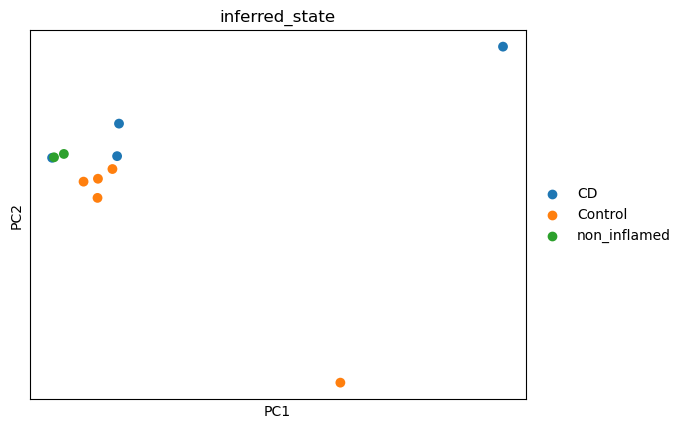

In [87]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'inferred_state', size = 200)

In [88]:
stat_res = DeseqStats(dds, contrast=('inferred_state', 'CD', 'Control'))
    
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: inferred_state CD vs Control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
index                                                                         
RP11-34P13.3  0.000000             NaN       NaN       NaN       NaN       NaN
FAM138A       0.000000             NaN       NaN       NaN       NaN       NaN
OR4F5         0.000000             NaN       NaN       NaN       NaN       NaN
RP11-34P13.7  0.166807       -0.967030  2.329989 -0.415036  0.678115  0.999921
RP11-34P13.8  0.000000             NaN       NaN       NaN       NaN       NaN
...                ...             ...       ...       ...       ...       ...
AC233755.2    0.024925        1.210581  3.851950  0.314277  0.753310  0.999921
AC233755.1    0.008308        0.904417  3.891459  0.232411  0.816219  0.999921
AC240274.1    0.133152        0.935658  2.373944  0.394136  0.693480  0.999921
AC213203.1    0.000000             NaN       NaN       NaN      

... done in 1.74 seconds.



# Sort the DGE results

In [89]:
de  = stat_res.results_df

In [90]:
de.sort_values('stat', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,
JCHAIN,93.494592,2.648249,0.532331,4.974817,6.530918e-07,0.011073
STAT1,16.031311,2.577078,0.558714,4.612520,3.978161e-06,0.022493
IGHA1,121.596634,3.142403,0.681290,4.612430,3.979887e-06,0.022493
MTRNR2L8,15.880953,4.058490,0.993090,4.086729,4.374985e-05,0.185445
GBP2,6.305237,2.818023,0.719767,3.915188,9.033397e-05,0.306322
...,...,...,...,...,...,...
AC007325.2,0.000000,NaN,NaN,NaN,NaN,NaN
BX072566.1,0.000000,NaN,NaN,NaN,NaN,NaN
AC023491.2,0.000000,NaN,NaN,NaN,NaN,NaN


In [91]:
filt_df = de[de['padj'] <= 0.05].sort_values('padj')
print(filt_df)

          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
index                                                                         
JCHAIN   93.494592        2.648249  0.532331  4.974817  6.530918e-07  0.011073
STAT1    16.031311        2.577078  0.558714  4.612520  3.978161e-06  0.022493
IGHA1   121.596634        3.142403  0.681290  4.612430  3.979887e-06  0.022493
